# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import sagemaker
import os
import seaborn as sn
import matplotlib.pyplot as plt

from statistics import mean 
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

%matplotlib inline

data_dir = 'data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [2]:
# read in the json files
portfolio = pd.read_json(os.path.join(data_dir, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(data_dir, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(data_dir, 'transcript.json'), orient='records', lines=True)

In [3]:
portfolio.shape[0]

10

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [118]:
profile.describe()[['age','income']]

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [6]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [7]:
print("offer recived: {}".format(transcript[transcript['event'] == 'offer received'].shape[0]))
print("offer viewed: {}".format(transcript[transcript['event'] == 'offer viewed'].shape[0]))
print("transaction: {}".format(transcript[transcript['event'] == 'transaction'].shape[0]))
print("offer completed: {}".format(transcript[transcript['event'] == 'offer completed'].shape[0]))

offer recived: 76277
offer viewed: 57725
transaction: 138953
offer completed: 33579


In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
transcript[transcript['event'] == 'transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [10]:
transcript[transcript['event'] == 'transaction'].head().iloc[0,2]

{'amount': 0.8300000000000001}

In [11]:
transcript[transcript['event'] == 'offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript[transcript['event'] == 'offer received'].head().iloc[0,2]

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [13]:
transcript[transcript['event'] == 'offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [14]:
transcript[transcript['event'] == 'offer viewed'].head().iloc[0,2]['offer id']

'f19421c1d4aa40978ebb69ca19b0e20d'

In [15]:
transcript[transcript['event'] == 'offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [16]:
transcript[transcript['event'] == 'offer completed'].head().iloc[0,2]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [17]:
completed_transcript = transcript[transcript['event'] == 'offer completed']
viewed_transcript = transcript[transcript['event'] == 'offer viewed']
recieved_transcript = transcript[transcript['event'] == 'offer received']
transaction_transcript = transcript[transcript['event'] == 'transaction']

completed_transcript = completed_transcript.reset_index(drop=True)
viewed_transcript = viewed_transcript.reset_index(drop=True)
recieved_transcript = recieved_transcript.reset_index(drop=True)
transaction_transcript = transaction_transcript.reset_index(drop=True)

viewed_transcript['value'] = [x['offer id'] for x in viewed_transcript['value']]
recieved_transcript['value'] = [x['offer id'] for x in recieved_transcript['value']]
completed_transcript['reward'] = [x['reward'] for x in completed_transcript['value']]
completed_transcript['value'] = [x['offer_id'] for x in completed_transcript['value']]
transaction_transcript['value'] = [x['amount'] for x in transaction_transcript['value']]

In [18]:
recieved_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [19]:
viewed_transcript.head()

,person,event,value,time
0,389bc3fa690240e798340f5a15918d5c,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0
1,d1ede868e29245ea91818a903fec04c6,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0
2,102e9454054946fda62242d2e176fdce,offer viewed,4d5c57ea9a6940dd891ad53e9dbe8da0,0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd,0
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0


In [20]:
completed_transcript.head()

,person,event,value,time,reward
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,2906b810c7d4411798c6938adc9daaa5,0,2
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,fafdcd668e3743c1bb461111dcafc2a4,0,2
2,629fc02d56414d91bca360decdfa9288,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5
3,676506bad68e4161b9bbaffeb039626b,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,0,10
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10


In [21]:
transaction_transcript.head()

,person,event,value,time
0,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0
2,54890f68699049c2a04d415abc25e717,transaction,13.23,0
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0


In [22]:
profile['total_spend'] = [
    transaction_transcript.loc[transaction_transcript['person'] == p,'value'].sum() for p in profile['id']
]

In [23]:
profile['completed_count'] = [
    (completed_transcript['person'] == p).sum() for p in profile['id']
]

profile['viewed_count'] = [
    (viewed_transcript['person'] == p).sum() for p in profile['id']
]

In [24]:
profile.head()

,gender,age,id,became_member_on,income,total_spend,completed_count,viewed_count
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,20.40,2,5
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,1,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,14.30,0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,3,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4.65,0,3


In [25]:
recieved_reviewed_completed = pd.DataFrame(columns = recieved_transcript.columns)

recieved_reviewed = pd.merge(viewed_transcript, recieved_transcript, on=['person','value'], how='inner')
recieved_reviewed_completed = pd.merge(recieved_reviewed, completed_transcript, on=['person','value'], how='inner')

time_valid = (recieved_reviewed_completed['time_x'] <= recieved_reviewed_completed['time_y']) & (recieved_reviewed_completed['time_y'] <= recieved_reviewed_completed['time'])
recieved_reviewed_completed = recieved_reviewed_completed[time_valid]

recieved_reviewed_completed = recieved_reviewed_completed.drop(['event_x','time_x','event_y','time_y','event','time', 'reward'], axis=1)

In [26]:
recieved_reviewed_completed.head()

,person,value
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
1,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
3,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
7,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
8,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
recieved_reviewed_not_completed = pd.DataFrame(columns = recieved_transcript.columns)

recieved_reviewed = pd.merge(viewed_transcript, recieved_transcript, on=['person','value'], how='inner')
recieved_reviewed_not_completed = pd.merge(recieved_reviewed, completed_transcript, on=['person','value'], how='left')

recieved_reviewed_not_completed = recieved_reviewed_not_completed[recieved_reviewed_not_completed['event'].isnull()]

time_valid = (recieved_reviewed_not_completed['time_x'] <= recieved_reviewed_not_completed['time_y']) 
recieved_reviewed_not_completed = recieved_reviewed_not_completed[time_valid]

recieved_reviewed_not_completed = recieved_reviewed_not_completed.drop(['event_x','time_x','event_y','time_y','event','time', 'reward'], axis=1)

In [28]:
recieved_reviewed_not_completed.head()

,person,value
8,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837
10,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd
11,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837
14,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2
15,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2


In [29]:
recieved_not_reviewed = pd.DataFrame(columns = recieved_transcript.columns)

recieved_not_reviewed = pd.merge(recieved_transcript, viewed_transcript, on=['person','value'], how='left')

recieved_not_reviewed = recieved_not_reviewed[recieved_not_reviewed['event_y'].isnull()]

recieved_not_reviewed = recieved_not_reviewed.drop(['event_x','time_x','event_y','time_y'], axis=1)

In [30]:
recieved_not_reviewed.head()

,person,value
11,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed
26,65aba5c617294649aeb624da249e1ee5,2906b810c7d4411798c6938adc9daaa5
29,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5
32,4beeb3ed64dd4898b0edf2f6b67426d3,2906b810c7d4411798c6938adc9daaa5
34,25c906289d154b66bf579693f89481c9,2906b810c7d4411798c6938adc9daaa5


In [31]:
completed_not_viewed = pd.DataFrame(columns = recieved_transcript.columns)

completed_not_viewed = pd.merge(completed_transcript, viewed_transcript, on=['person','value'], how='left')

completed_not_viewed = completed_not_viewed[completed_not_viewed['event_y'].isnull()]

completed_not_viewed = completed_not_viewed.drop(['event_x','time_x','event_y','time_y','reward'], axis=1)

In [32]:
completed_not_viewed.head()

,person,value
12,b860d355ef6e4c66b5d5a837c56ef32d,9b98b8c7a33c4b65b9aebfe6a799e6d9
14,24115a61df25473e84a8a03f3c98de1a,2906b810c7d4411798c6938adc9daaa5
19,2481f1fcfbcb4b288e5a03af02d95373,2906b810c7d4411798c6938adc9daaa5
28,16dc4306258b4fef90ffe99f53ed7952,9b98b8c7a33c4b65b9aebfe6a799e6d9
29,2c9a9137efff4820a47d56dbf0fa555f,f19421c1d4aa40978ebb69ca19b0e20d


In [51]:
# good_offers_with_labels =
bad_offers = recieved_reviewed_not_completed.append(recieved_not_reviewed)
good_offers = recieved_reviewed_completed

In [52]:
good_offers.head()

,person,value
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
1,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
3,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
7,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
8,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0


In [53]:
bad_offers.head()

,person,value
8,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837
10,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd
11,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837
14,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2
15,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2


In [54]:
def fetch_person_offer_data(data,offers,profile,set_class=False):
    data_offers = pd.merge(data, profile, left_on = 'person', right_on = 'id', how='inner')
    data_offers_profile = pd.merge(data_offers, offers, left_on = 'value', right_on = 'id', how='inner')
    if set_class == False:
        data_offers_profile['class'] = 0 
    return data_offers_profile.drop(['person','value','id_x','id_y','channels'], axis=1)

In [55]:
bad_offers = fetch_person_offer_data(bad_offers,portfolio,profile,set_class=True)
good_offers = fetch_person_offer_data(good_offers,portfolio,profile,set_class=True)

In [56]:
bad_offers['Class'] = 0 
good_offers['Class'] = 1

In [57]:
bad_offers.head()

,gender,age,became_member_on,income,total_spend,completed_count,viewed_count,reward,difficulty,duration,offer_type,Class
0,O,53,20170916,52000.0,18.74,1,3,0,0,3,informational,0
1,M,39,20140527,51000.0,51.91,1,3,0,0,3,informational,0
2,M,40,20180227,53000.0,8.17,0,3,0,0,3,informational,0
3,None,118,20170823,NaN,1.09,0,6,0,0,3,informational,0
4,F,51,20170813,56000.0,40.94,2,4,0,0,3,informational,0


In [58]:
good_offers.head()

,gender,age,became_member_on,income,total_spend,completed_count,viewed_count,reward,difficulty,duration,offer_type,Class
0,M,65,20180209,53000.0,36.43,5,6,5,5,5,bogo,1
1,M,65,20180209,53000.0,36.43,5,6,5,5,5,bogo,1
2,M,65,20180209,53000.0,36.43,5,6,5,5,5,bogo,1
3,M,65,20180209,53000.0,36.43,5,6,5,5,5,bogo,1
4,F,39,20170919,60000.0,705.50,3,4,5,5,5,bogo,1


In [59]:
data = good_offers.append(bad_offers)
data = data.sample(frac=1).reset_index(drop=True)
data.dropna(subset = data.columns.values, inplace=True)

In [60]:
data.head()

,gender,age,became_member_on,income,total_spend,completed_count,viewed_count,reward,difficulty,duration,offer_type,Class
1,F,70,20180505,71000.0,28.84,1,4,10,10,7,bogo,0
3,M,63,20180201,86000.0,42.58,1,4,5,5,7,bogo,0
5,F,59,20171030,93000.0,103.17,3,4,5,5,7,bogo,0
6,M,50,20180324,81000.0,53.46,4,2,2,10,7,discount,0
8,F,54,20151216,77000.0,163.77,3,2,0,0,4,informational,0


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35438 entries, 1 to 40427
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            35438 non-null  object 
 1   age               35438 non-null  int64  
 2   became_member_on  35438 non-null  int64  
 3   income            35438 non-null  float64
 4   total_spend       35438 non-null  float64
 5   completed_count   35438 non-null  int64  
 6   viewed_count      35438 non-null  int64  
 7   reward            35438 non-null  int64  
 8   difficulty        35438 non-null  int64  
 9   duration          35438 non-null  int64  
 10  offer_type        35438 non-null  object 
 11  Class             35438 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 3.5+ MB


In [62]:
print(["class {} : {}".format(i,data[data['Class'] == i].shape[0]) for i in range(2)]) 

['class 0 : 22077', 'class 1 : 13361']


In [63]:
genders = { key : index for index,key in enumerate(list(data['gender'].unique())) } 
offer_type = { key : index for index,key in enumerate(list(data['offer_type'].unique())) }


data['gender'] = [ genders[x] for x in data['gender'] ]
data['offer_type'] = [ offer_type[x] for x in data['offer_type'] ]

In [64]:
data.head()

,gender,age,became_member_on,income,total_spend,completed_count,viewed_count,reward,difficulty,duration,offer_type,Class
1,0,70,20180505,71000.0,28.84,1,4,10,10,7,0,0
3,1,63,20180201,86000.0,42.58,1,4,5,5,7,0,0
5,0,59,20171030,93000.0,103.17,3,4,5,5,7,0,0
6,1,50,20180324,81000.0,53.46,4,2,2,10,7,1,0
8,0,54,20151216,77000.0,163.77,3,2,0,0,4,2,0


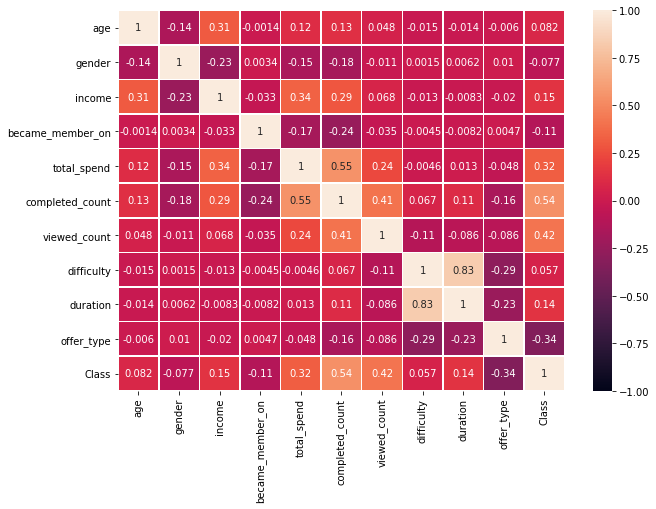

In [125]:
corrMatrix = data.loc[:,['age','gender','income','became_member_on','total_spend','completed_count','viewed_count','difficulty','duration','offer_type','Class']].corr()
fig, ax = plt.subplots(figsize=(10,7))  
sn.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax , vmin=-1, vmax=1)
plt.show()

In [80]:
samples = data.loc[:,['age','gender','income','became_member_on','total_spend','completed_count','viewed_count','difficulty','duration','offer_type']]
labels = np.array(data['Class'])

In [81]:
samples.head()

,age,gender,income,became_member_on,total_spend,completed_count,viewed_count,difficulty,duration,offer_type
1,70,0,71000.0,20180505,28.84,1,4,10,7,0
3,63,1,86000.0,20180201,42.58,1,4,5,7,0
5,59,0,93000.0,20171030,103.17,3,4,5,7,0
6,50,1,81000.0,20180324,53.46,4,2,10,7,1
8,54,0,77000.0,20151216,163.77,3,2,0,4,2


In [82]:
labels[1:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 0])

In [83]:


samples_array = samples.values

scaler = MinMaxScaler()
scaler.fit(samples_array)

samples_array = scaler.fit_transform(samples_array)

samples_columns = samples.columns
samples = pd.DataFrame(samples_array)
samples.columns = samples_columns

In [84]:
samples.describe()

,age,gender,income,became_member_on,total_spend,completed_count,viewed_count,difficulty,duration,offer_type
count,35438.000000,35438.000000,35438.000000,35438.000000,35438.000000,35438.000000,35438.000000,35438.000000,35438.000000,35438.000000
mean,0.438426,0.300694,0.391001,0.725063,0.075840,0.395827,0.574746,0.407766,0.525312,0.410393
std,0.210644,0.258763,0.239703,0.234124,0.084720,0.284984,0.229456,0.297972,0.317251,0.365275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.289157,0.000000,0.211111,0.595936,0.018524,0.166667,0.333333,0.250000,0.285714,0.000000
50%,0.445783,0.500000,0.366667,0.801508,0.055713,0.333333,0.500000,0.500000,0.571429,0.500000
75%,0.590361,0.500000,0.544444,0.810029,0.105197,0.666667,0.666667,0.500000,0.571429,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
samples.head()

,age,gender,income,became_member_on,total_spend,completed_count,viewed_count,difficulty,duration,offer_type
0,0.626506,0.0,0.455556,0.995580,0.017928,0.166667,0.666667,0.50,0.571429,0.0
1,0.542169,0.5,0.622222,0.989499,0.026469,0.166667,0.666667,0.25,0.571429,0.0
2,0.493976,0.0,0.700000,0.806068,0.064133,0.500000,0.666667,0.25,0.571429,0.0
3,0.385542,0.5,0.566667,0.991960,0.033232,0.666667,0.333333,0.50,0.571429,0.5
4,0.433735,0.0,0.522222,0.409765,0.101803,0.500000,0.333333,0.00,0.142857,1.0


In [86]:
train_X, test_X , train_Y, test_Y = train_test_split(samples.values, labels, test_size=0.2, random_state=1)
train_X, val_X , train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=1)

In [87]:
print("size of train_X , {}".format(train_X.shape))
print("size of train_Y , {}".format(train_Y.shape))
print("size of test_X , {}".format(test_X.shape))
print("size of test_Y , {}".format(test_Y.shape))
print("size of val_X , {}".format(val_X.shape))
print("size of val_Y , {}".format(val_Y.shape))

size of train_X , (22680, 10)
size of train_Y , (22680,)
size of test_X , (7088, 10)
size of test_Y , (7088,)
size of val_X , (5670, 10)
size of val_Y , (5670,)


In [88]:
pd.concat([pd.DataFrame(train_Y), pd.DataFrame(train_X)], axis=1)

,0,0,1,2,3,4,5,6,7,8,9
0,0,0.481928,0.5,0.655556,0.799628,0.126003,0.666667,0.333333,0.50,0.571429,0.0
1,0,0.722892,0.5,0.700000,0.410065,0.097098,0.500000,0.333333,1.00,1.000000,0.5
2,0,0.289157,0.5,0.377778,0.995780,0.022441,0.166667,0.666667,0.00,0.142857,1.0
3,0,0.457831,0.5,0.222222,0.993580,0.016691,0.333333,0.500000,1.00,1.000000,0.5
4,1,0.421687,0.0,0.877778,0.589715,0.123193,0.500000,0.500000,0.25,0.285714,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22675,1,0.493976,0.0,0.422222,0.593596,0.171481,0.500000,0.666667,0.35,0.571429,0.5
22676,0,0.759036,0.0,0.033333,0.604016,0.028321,0.333333,0.500000,1.00,1.000000,0.5
22677,0,0.108434,0.5,0.144444,0.409645,0.018935,0.166667,0.500000,0.50,0.571429,0.0
22678,0,0.518072,0.0,0.988889,0.793508,0.619734,0.500000,0.166667,0.50,0.571429,0.0


In [89]:
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([pd.DataFrame(train_Y), pd.DataFrame(train_X)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([pd.DataFrame(val_Y), pd.DataFrame(val_X)], axis=1).to_csv(os.path.join(data_dir, 'val.csv'), header=False, index=False)

# SageMaker Config

In [90]:
session = sagemaker.Session() # Store the current SageMaker session

# S3 prefix (which folder will we use)
prefix = 'starbucks-recommender-model'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'val.csv'), key_prefix=prefix)


s3_input_train = sagemaker.s3_input(s3_data=train_location,content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location,content_type='text/csv')
s3_input_test = sagemaker.s3_input(s3_data=test_location,content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [91]:
# Our current execution role is require when creating the model as the training
# and inference code will need to access the model artifacts.
role = get_execution_role()

In [111]:
def evaluate(test_labels,pred_labels):
    prec, rec, fbeta_test, support = precision_recall_fscore_support(test_labels, pred_labels, average = None)
    roc = roc_auc_score(test_labels,pred_labels)
    print("ROC : {}".format(roc))
    print("percision : {}".format(mean(prec)))
    print("recall : {}".format(mean(rec)))
    print("f1 score : {}".format(mean(fbeta_test)))

# XGboost Training and Deploying

In [94]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
container = get_image_uri(session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=15,
                        alpha=0.01,
                        min_child_weight=6,
                        eta=0.4,
                        silent=0,
                        objective='multi:softmax',
                        num_class=2,
                        num_round=350)

xgb.fit({'train':s3_input_train , 'validation':s3_input_validation})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-25 07:26:20 Starting - Starting the training job...
2020-08-25 07:26:22 Starting - Launching requested ML instances......
2020-08-25 07:27:26 Starting - Preparing the instances for training...
2020-08-25 07:28:16 Downloading - Downloading input data...
2020-08-25 07:28:50 Training - Training image download completed. Training in progress..Arguments: train
[2020-08-25:07:28:51:INFO] Running standalone xgboost training.
[2020-08-25:07:28:51:INFO] File size need to be processed in the node: 3.72mb. Available memory size in the node: 8486.63mb
[2020-08-25:07:28:51:INFO] Determined delimiter of CSV input is ','
[07:28:51] S3DistributionType set as FullyReplicated
[07:28:51] 22680x10 matrix with 226800 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-25:07:28:51:INFO] Determined delimiter of CSV input is ','
[07:28:51] S3DistributionType set as FullyReplicated
[07:28:51] 5670x10 matrix with 56700 entries loaded from /opt/ml/input/data/valida

In [95]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [96]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [97]:
xgb_transformer.wait()

...........................
2020-08-25T07:34:09.313:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-08-25 07:34:09 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-25 07:34:09 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-25 07:34:09 +0000] [1] [INFO] Using worker: gevent
[2020-08-25 07:34:09 +0000] [37] [INFO] Booting worker with pid: 37
[2020-08-25 07:34:09 +0000] [38] [INFO] Booting worker with pid: 38
[2020-08-25 07:34:09 +0000] [39] [INFO] Booting worker with pid: 39
[2020-08-25:07:34:09:INFO] Model loaded successfully for worker : 38
[2020-08-25:07:34:09:INFO] Model loaded successfully for worker : 37
[2020-08-25 07:34:09 +0000] [40] [INFO] Booting worker with pid: 40
Arguments: serve
[2020-08-25 07:34:09 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-25 07:34:09 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-25 07:34:09 +0000] [1] [INFO] Using worker: gevent
[2020-08-25 

In [126]:
xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: xgboost-2020-08-25-07-26-20-597


---------------!

In [98]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-613763915925/xgboost-2020-08-25-07-29-45-682/test.csv.out to data/test.csv.out


In [99]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [112]:
evaluate(test_Y,predictions)

ROC : 0.8983825196884648
percision : 0.8957393930425892
recall : 0.8983825196884648
f1 score : 0.8970147701100086


# Linear learner (Bench Mark)

In [106]:
multiclass_estimator = sagemaker.LinearLearner(role=role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier')

In [107]:
train_X = np.array(train_X,dtype='float32')
train_Y = np.array(train_Y,dtype='float32')

val_X = np.array(val_X,dtype='float32')
val_Y = np.array(val_Y,dtype='float32')

test_X = np.array(test_X,dtype='float32')
test_Y = np.array(test_Y,dtype='float32')

train_records = multiclass_estimator.record_set(train_X, train_Y, channel='train')
val_records = multiclass_estimator.record_set(val_X,val_Y, channel='validation')
test_records = multiclass_estimator.record_set(test_X, test_Y, channel='test')

In [108]:
multiclass_estimator.fit([train_records, val_records, test_records])

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-25 07:38:01 Starting - Starting the training job...
2020-08-25 07:38:03 Starting - Launching requested ML instances......
2020-08-25 07:39:07 Starting - Preparing the instances for training......
2020-08-25 07:40:21 Downloading - Downloading input data...
2020-08-25 07:40:53 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script

2020-08-25 07:41:13 Training - Training image download completed. Training in progress.[08/25/2020 07:41:17 INFO 139803683780416] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u

In [114]:
multiclass_predictor = multiclass_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: linear-learner-2020-08-25-07-38-01-533


---------------!

In [115]:
predictions = multiclass_predictor.predict(np.array(test_X,dtype='float32'))

extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
predictions = [extract_label(sample) for sample in predictions]

In [116]:
evaluate(test_Y,predictions)

ROC : 0.8146921664331954
percision : 0.807942801993055
recall : 0.8146921664331955
f1 score : 0.8108132711979447
